# Load data from a tar file into PyART
A common worklow is reading data from a tar (compressed) file.

Currently, the pyart.io module does not allow you to read these data directly - this notebook shows a new method of working around this, using xarray (which uses scipy's netcdf reader)!

In [4]:
import os
import tarfile
import pyart
import glob
import xarray as xr

import datetime
import getpass
import platform
import warnings

import netCDF4
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import warnings

import pyart
from pyart.config import FileMetadata
from pyart.io.common import stringarray_to_chararray, _test_arguments
from pyart.core.radar import Radar
from pyart.lazydict import LazyLoadDict
xr.set_options(keep_attrs=True)
warnings.filterwarnings("ignore")

## Let's modify the `pyart.io.read_cfradial` function

In [5]:
# Variables and dimensions in the instrument_parameter convention and
# radar_parameters sub-convention that will be read from and written to
# CfRadial files using Py-ART.
# The meta_group attribute cannot be used to identify these parameters as
# it is often set incorrectly.
_INSTRUMENT_PARAMS_DIMS = {
    # instrument_parameters sub-convention
    'frequency': ('frequency'),
    'follow_mode': ('sweep', 'string_length'),
    'pulse_width': ('time', ),
    'prt_mode': ('sweep', 'string_length'),
    'prt': ('time', ),
    'prt_ratio': ('time', ),
    'polarization_mode': ('sweep', 'string_length'),
    'nyquist_velocity': ('time', ),
    'unambiguous_range': ('time', ),
    'n_samples': ('time', ),
    'sampling_ratio': ('time', ),
    # radar_parameters sub-convention
    'radar_antenna_gain_h': (),
    'radar_antenna_gain_v': (),
    'radar_beam_width_h': (),
    'radar_beam_width_v': (),
    'radar_receiver_bandwidth': (),
    'radar_measured_transmit_power_h': ('time', ),
    'radar_measured_transmit_power_v': ('time', ),
    'radar_rx_bandwidth': (),           # non-standard
    'measured_transmit_power_v': ('time', ),    # non-standard
    'measured_transmit_power_h': ('time', ),    # non-standard
}


def read_cfradial(filename, field_names=None, additional_metadata=None,
                  file_field_names=False, exclude_fields=None,
                  include_fields=None, delay_field_loading=False, **kwargs):
    """
    Read a Cfradial netCDF file.
    Parameters
    ----------
    filename : str
        Name of CF/Radial netCDF file to read data from.
    field_names : dict, optional
        Dictionary mapping field names in the file names to radar field names.
        Unlike other read functions, fields not in this dictionary or having a
        value of None are still included in the radar.fields dictionary, to
        exclude them use the `exclude_fields` parameter. Fields which are
        mapped by this dictionary will be renamed from key to value.
    additional_metadata : dict of dicts, optional
        This parameter is not used, it is included for uniformity.
    file_field_names : bool, optional
        True to force the use of the field names from the file in which
        case the `field_names` parameter is ignored. False will use to
        `field_names` parameter to rename fields.
    exclude_fields : list or None, optional
        List of fields to exclude from the radar object. This is applied
        after the `file_field_names` and `field_names` parameters. Set
        to None to include all fields specified by include_fields.
    include_fields : list or None, optional
        List of fields to include from the radar object. This is applied
        after the `file_field_names` and `field_names` parameters. Set
        to None to include all fields not specified by exclude_fields.
    delay_field_loading : bool
        True to delay loading of field data from the file until the 'data'
        key in a particular field dictionary is accessed. In this case
        the field attribute of the returned Radar object will contain
        LazyLoadDict objects not dict objects. Delayed field loading will not
        provide any speedup in file where the number of gates vary between
        rays (ngates_vary=True) and is not recommended.
    Returns
    -------
    radar : Radar
        Radar object.
    Notes
    -----
    This function has not been tested on "stream" Cfradial files.
    """
    # test for non empty kwargs
    _test_arguments(kwargs)

    # create metadata retrieval object
    filemetadata = FileMetadata('cfradial', field_names, additional_metadata,
                                file_field_names, exclude_fields)

    # read the data
    ncobj = xr.open_dataset(filename, decode_times=False)
    ncvars = ncobj

    # 4.1 Global attribute -> move to metadata dictionary
    metadata = dict([(k, getattr(ncobj, k)) for k in ncobj.attrs])
    if 'n_gates_vary' in metadata:
        metadata['n_gates_vary'] = 'false'  # corrected below

    # 4.2 Dimensions (do nothing)

    # 4.3 Global variable -> move to metadata dictionary
    if 'volume_number' in ncvars:
        if np.ma.isMaskedArray(ncvars['volume_number']):
            metadata['volume_number'] = int(
                np.ma.getdata(ncvars['volume_number'].flatten()))
        else:
            metadata['volume_number'] = int(ncvars['volume_number'])
    else:
        metadata['volume_number'] = 0

    global_vars = {'platform_type': 'fixed', 'instrument_type': 'radar',
                   'primary_axis': 'axis_z'}
    # ignore time_* global variables, these are calculated from the time
    # variable when the file is written.
    for var, default_value in global_vars.items():
        if var in ncvars:
            metadata[var] = str(netCDF4.chartostring(ncvars[var][:]))
        else:
            metadata[var] = default_value

    # 4.4 coordinate variables -> create attribute dictionaries
    time = _ncvar_to_dict(ncvars['time'])
    _range = _ncvar_to_dict(ncvars['range'])

    # 4.5 Ray dimension variables

    # 4.6 Location variables -> create attribute dictionaries
    latitude = _ncvar_to_dict(ncvars['latitude'])
    longitude = _ncvar_to_dict(ncvars['longitude'])
    altitude = _ncvar_to_dict(ncvars['altitude'])
    if 'altitude_agl' in ncvars:
        altitude_agl = _ncvar_to_dict(ncvars['altitude_agl'])
    else:
        altitude_agl = None

    # 4.7 Sweep variables -> create atrribute dictionaries
    sweep_mode = _ncvar_to_dict(ncvars['sweep_mode'])
    fixed_angle = _ncvar_to_dict(ncvars['fixed_angle'])
    sweep_start_ray_index = _ncvar_to_dict(ncvars['sweep_start_ray_index'])
    sweep_end_ray_index = _ncvar_to_dict(ncvars['sweep_end_ray_index'])

    if 'sweep_number' in ncvars:
        sweep_number = _ncvar_to_dict(ncvars['sweep_number'])
    else:
        nsweeps = len(sweep_start_ray_index['data'])
        sweep_number = filemetadata('sweep_number')
        sweep_number['data'] = np.arange(nsweeps, dtype='float32')
        warnings.warn("Warning: File violates CF/Radial convention. " +
                      "Missing sweep_number variable")

    if 'target_scan_rate' in ncvars:
        target_scan_rate = _ncvar_to_dict(ncvars['target_scan_rate'])
    else:
        target_scan_rate = None
    if 'rays_are_indexed' in ncvars:
        rays_are_indexed = _ncvar_to_dict(ncvars['rays_are_indexed'])
    else:
        rays_are_indexed = None
    if 'ray_angle_res' in ncvars:
        ray_angle_res = _ncvar_to_dict(ncvars['ray_angle_res'])
    else:
        ray_angle_res = None

    # Uses ARM scan name if present.
    if hasattr(ncobj, 'scan_name'):
        mode = ncobj.scan_name
    else:
        # first sweep mode determines scan_type
        try:
            mode = sweep_mode['data'].astype(str)[0]
        except AttributeError:
            # Python 3, all strings are already unicode.
            mode = netCDF4.chartostring(sweep_mode['data'][0])[()]

    mode = mode.strip()

    # options specified in the CF/Radial standard
    if mode == 'rhi':
        scan_type = 'rhi'
    elif mode == 'vertical_pointing':
        scan_type = 'vpt'
    elif mode == 'azimuth_surveillance':
        scan_type = 'ppi'
    elif mode == 'elevation_surveillance':
        scan_type = 'rhi'
    elif mode == 'manual_ppi':
        scan_type = 'ppi'
    elif mode == 'manual_rhi':
        scan_type = 'rhi'

    # fallback types
    elif 'sur' in mode:
        scan_type = 'ppi'
    elif 'sec' in mode:
        scan_type = 'sector'
    elif 'rhi' in mode:
        scan_type = 'rhi'
    elif 'ppi' in mode:
        scan_type = 'ppi'
    else:
        scan_type = 'other'

    # 4.8 Sensor pointing variables -> create attribute dictionaries
    azimuth = _ncvar_to_dict(ncvars['azimuth'])
    elevation = _ncvar_to_dict(ncvars['elevation'])
    if 'scan_rate' in ncvars:
        scan_rate = _ncvar_to_dict(ncvars['scan_rate'])
    else:
        scan_rate = None

    if 'antenna_transition' in ncvars:
        antenna_transition = _ncvar_to_dict(ncvars['antenna_transition'])
    else:
        antenna_transition = None

    # 4.9 Moving platform geo-reference variables
    # Aircraft specific varaibles
    if 'rotation' in ncvars:
        rotation = _ncvar_to_dict(ncvars['rotation'])
    else:
        rotation = None

    if 'tilt' in ncvars:
        tilt = _ncvar_to_dict(ncvars['tilt'])
    else:
        tilt = None

    if 'roll' in ncvars:
        roll = _ncvar_to_dict(ncvars['roll'])
    else:
        roll = None

    if 'drift' in ncvars:
        drift = _ncvar_to_dict(ncvars['drift'])
    else:
        drift = None

    if 'heading' in ncvars:
        heading = _ncvar_to_dict(ncvars['heading'])
    else:
        heading = None

    if 'pitch' in ncvars:
        pitch = _ncvar_to_dict(ncvars['pitch'])
    else:
        pitch = None

    if 'georefs_applied' in ncvars:
        georefs_applied = _ncvar_to_dict(ncvars['georefs_applied'])
    else:
        georefs_applied = None

    # 4.10 Moments field data variables -> field attribute dictionary
    if 'ray_n_gates' in ncvars:
        # all variables with dimensions of n_points are fields.
        keys = [k for k, v in ncvars.items()
                if v.dims == ('n_points', )]
    else:
        # all variables with dimensions of 'time', 'range' are fields
        keys = [k for k, v in ncvars.items()
                if v.dims == ('time', 'range')]

    fields = {}
    for key in keys:
        field_name = filemetadata.get_field_name(key)
        if field_name is None:
            if exclude_fields is not None and key in exclude_fields:
                if key not in include_fields:
                    continue
            if include_fields is None or key in include_fields:
                field_name = key
            else:
                continue
        fields[field_name] = _ncvar_to_dict(ncvars[key], delay_field_loading)

    if 'ray_n_gates' in ncvars:
        shape = (len(ncvars['time']), len(ncvars['range']))
        ray_n_gates = ncvars['ray_n_gates'][:]
        ray_start_index = ncvars['ray_start_index'][:]
        for dic in fields.values():
            _unpack_variable_gate_field_dic(
                dic, shape, ray_n_gates, ray_start_index)

    # 4.5 instrument_parameters sub-convention -> instrument_parameters dict
    # 4.6 radar_parameters sub-convention -> instrument_parameters dict
    keys = [k for k in _INSTRUMENT_PARAMS_DIMS.keys() if k in ncvars]
    instrument_parameters = dict((k, _ncvar_to_dict(ncvars[k])) for k in keys)
    if instrument_parameters == {}:  # if no parameters set to None
        instrument_parameters = None

    # 4.7 lidar_parameters sub-convention -> skip

    # 4.8 radar_calibration sub-convention -> radar_calibration
    keys = _find_all_meta_group_vars(ncvars, 'radar_calibration')
    radar_calibration = dict((k, _ncvar_to_dict(ncvars[k])) for k in keys)
    if radar_calibration == {}:
        radar_calibration = None

    # do not close file if field loading is delayed
    if not delay_field_loading:
        ncobj.close()
    return Radar(
        time, _range, fields, metadata, scan_type,
        latitude, longitude, altitude,
        sweep_number, sweep_mode, fixed_angle, sweep_start_ray_index,
        sweep_end_ray_index,
        azimuth, elevation,
        instrument_parameters=instrument_parameters,
        radar_calibration=radar_calibration,
        altitude_agl=altitude_agl,
        scan_rate=scan_rate,
        antenna_transition=antenna_transition,
        target_scan_rate=target_scan_rate,
        rays_are_indexed=rays_are_indexed, ray_angle_res=ray_angle_res,
        rotation=rotation, tilt=tilt, roll=roll, drift=drift, heading=heading,
        pitch=pitch, georefs_applied=georefs_applied)


def _find_all_meta_group_vars(ncvars, meta_group_name):
    """
    Return a list of all variables which are in a given meta_group.
    """
    return [k for k, v in ncvars.items() if 'meta_group' in v.attrs and
            v.meta_group == meta_group_name]


def _ncvar_to_dict(ncvar, lazydict=False):
    """ Convert a NetCDF Dataset variable to a dictionary. """
    # copy all attribute except for scaling parameters
    d = dict((k, getattr(ncvar, k)) for k in ncvar.attrs
             if k not in ['scale_factor', 'add_offset'])
    data_extractor = _NetCDFVariableDataExtractor(ncvar)
    if lazydict:
        d = LazyLoadDict(d)
        d.set_lazy('data', data_extractor)
    else:
        d['data'] = data_extractor()
    return d


class _NetCDFVariableDataExtractor(object):
    """
    Class facilitating on demand extraction of data from a NetCDF variable.
    Parameters
    ----------
    ncvar : netCDF4.Variable
        NetCDF Variable from which data will be extracted.
    """

    def __init__(self, ncvar):
        """ initialize the object. """
        self.ncvar = ncvar

    def __call__(self):
        """ Return an array containing data from the stored variable. """
        data = self.ncvar.data
        if data is np.ma.masked:
            # If the data is a masked scalar, MaskedConstant is returned by
            # NetCDF4 version 1.2.3+. This object does not preserve the dtype
            # and fill_value of the original NetCDF variable and causes issues
            # in Py-ART.
            # Rather we create a masked array with a single masked value
            # with the correct dtype and fill_value.
            self.ncvar.set_auto_mask(False)
            data = np.ma.array(self.ncvar[:], mask=True)
        # Use atleast_1d to force the array to be at minimum one dimensional,
        # some version of netCDF return scalar or scalar arrays for scalar
        # NetCDF variables.
        return np.atleast_1d(data)


def _unpack_variable_gate_field_dic(
        dic, shape, ray_n_gates, ray_start_index):
    """ Create a 2D array from a 1D field data, dic update in place. """
    fdata = dic['data']
    data = np.ma.masked_all(shape, dtype=fdata.dtype)
    for i, (gates, idx) in enumerate(zip(ray_n_gates, ray_start_index)):
        data[i, :gates] = fdata[idx:idx+gates]
    dic['data'] = data
    return

def plot_radar(radar):
    fig = plt.figure(figsize=[10, 6])
    display = pyart.graph.RadarMapDisplay(radar)
    display.plot_ppi_map('snow_z',
                         vmin=0.0,
                         vmax=smax,
                         projection=ccrs.PlateCarree(),
                         cmap='pyart_HomeyerRainbow')

    plt.xlim(-107.1, -106.8)
    plt.ylim(38.8, 39.1)
    plt.show()
    plt.close()



## Read in our Data
First, we point to our data file

In [9]:
radar_path = r'C:/Users/matth/Downloads/'
rdr_files = os.listdir(radar_path)
file = 'gucxprecipradarS2.00.20220314.025559.raw.nc.tar'


Join our path and file name

In [10]:
filename = os.path.join(radar_path, file)

Next, we run through the untar process

In [14]:
tar = tarfile.open(filename,
                   mode='r:*')
flist = [tar.extractfile(member) for member in tar.getmembers()]

Now that we have our filelist, we can read our files into PyART!

In [15]:
radars = []
for untarred_file in flist:
    radars.append(read_cfradial(untarred_file))

Next we will pull in the PPI scan type data and have it select the 1 deg scan data. Currently this process is a bit more crude than I'd like in the future, but it'll be modified as time goes on.

elevation angle is: 10.0 deg
elevation angle is: 12.0 deg
elevation angle is: 15.0 deg
scan type is an RHI at:  2022-03-14 02:57:38
scan type is an RHI at:  2022-03-14 02:57:44
scan type is an RHI at:  2022-03-14 02:57:49
scan type is an RHI at:  2022-03-14 02:57:55
scan type is an RHI at:  2022-03-14 02:58:01
scan type is an RHI at:  2022-03-14 02:58:07
scan type is an RHI at:  2022-03-14 02:58:13


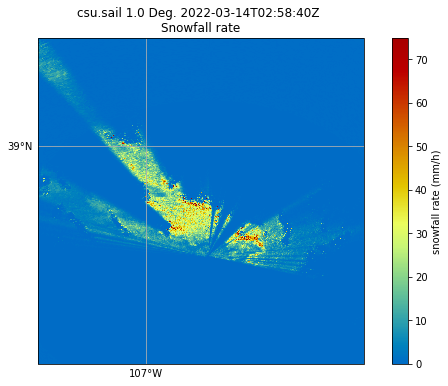

elevation angle is: 2.0 deg
elevation angle is: 4.0 deg
elevation angle is: 6.0 deg
elevation angle is: 8.0 deg
elevation angle is: 10.0 deg
elevation angle is: 12.0 deg
elevation angle is: 15.0 deg
scan type is an RHI at:  2022-03-14 03:02:58
scan type is an RHI at:  2022-03-14 03:03:04
scan type is an RHI at:  2022-03-14 03:03:09
scan type is an RHI at:  2022-03-14 03:03:15
scan type is an RHI at:  2022-03-14 03:03:21
scan type is an RHI at:  2022-03-14 03:03:27
scan type is an RHI at:  2022-03-14 03:03:33


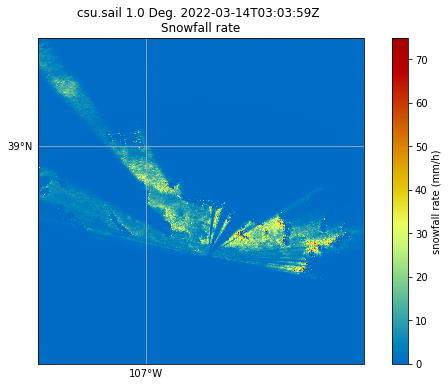

elevation angle is: 2.0 deg
elevation angle is: 4.0 deg
elevation angle is: 6.0 deg
elevation angle is: 8.0 deg
elevation angle is: 10.0 deg
elevation angle is: 12.0 deg
elevation angle is: 15.0 deg
scan type is an RHI at:  2022-03-14 03:08:18
scan type is an RHI at:  2022-03-14 03:08:24
scan type is an RHI at:  2022-03-14 03:08:29
scan type is an RHI at:  2022-03-14 03:08:35
scan type is an RHI at:  2022-03-14 03:08:41
scan type is an RHI at:  2022-03-14 03:08:47
scan type is an RHI at:  2022-03-14 03:08:53


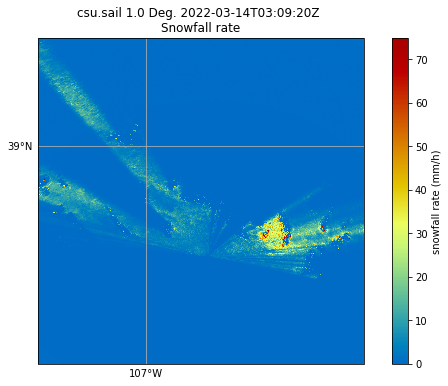

elevation angle is: 2.0 deg
elevation angle is: 4.0 deg
elevation angle is: 6.0 deg
elevation angle is: 8.0 deg
elevation angle is: 10.0 deg
elevation angle is: 12.0 deg
elevation angle is: 15.0 deg
scan type is an RHI at:  2022-03-14 03:13:38
scan type is an RHI at:  2022-03-14 03:13:44
scan type is an RHI at:  2022-03-14 03:13:50
scan type is an RHI at:  2022-03-14 03:13:55
scan type is an RHI at:  2022-03-14 03:14:01
scan type is an RHI at:  2022-03-14 03:14:07
scan type is an RHI at:  2022-03-14 03:14:13


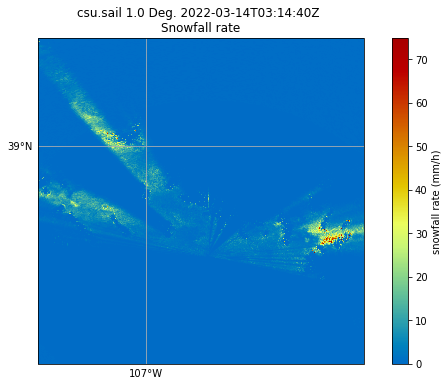

elevation angle is: 2.0 deg
elevation angle is: 4.0 deg
elevation angle is: 6.0 deg
elevation angle is: 8.0 deg
elevation angle is: 10.0 deg
elevation angle is: 12.0 deg
elevation angle is: 15.0 deg
scan type is an RHI at:  2022-03-14 03:18:58
scan type is an RHI at:  2022-03-14 03:19:04
scan type is an RHI at:  2022-03-14 03:19:10
scan type is an RHI at:  2022-03-14 03:19:15
scan type is an RHI at:  2022-03-14 03:19:21
scan type is an RHI at:  2022-03-14 03:19:27
scan type is an RHI at:  2022-03-14 03:19:33


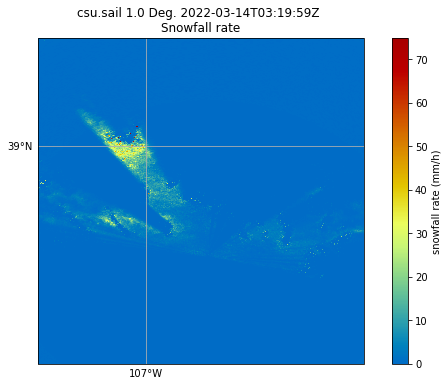

elevation angle is: 2.0 deg
elevation angle is: 4.0 deg
elevation angle is: 6.0 deg
elevation angle is: 8.0 deg
elevation angle is: 10.0 deg
elevation angle is: 12.0 deg
elevation angle is: 15.0 deg
scan type is an RHI at:  2022-03-14 03:24:18
scan type is an RHI at:  2022-03-14 03:24:24
scan type is an RHI at:  2022-03-14 03:24:30
scan type is an RHI at:  2022-03-14 03:24:35
scan type is an RHI at:  2022-03-14 03:24:41
scan type is an RHI at:  2022-03-14 03:24:47
scan type is an RHI at:  2022-03-14 03:24:53


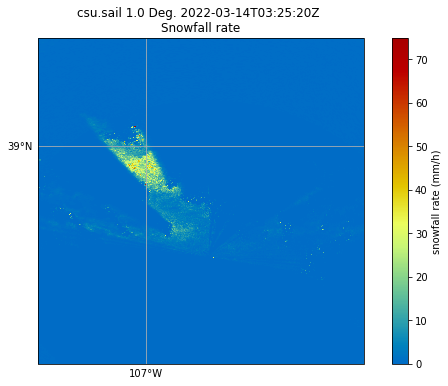

elevation angle is: 2.0 deg
elevation angle is: 4.0 deg
elevation angle is: 6.0 deg
elevation angle is: 8.0 deg
elevation angle is: 10.0 deg
elevation angle is: 12.0 deg
elevation angle is: 15.0 deg
scan type is an RHI at:  2022-03-14 03:29:38
scan type is an RHI at:  2022-03-14 03:29:44
scan type is an RHI at:  2022-03-14 03:29:50
scan type is an RHI at:  2022-03-14 03:29:56
scan type is an RHI at:  2022-03-14 03:30:01
scan type is an RHI at:  2022-03-14 03:30:07
scan type is an RHI at:  2022-03-14 03:30:13


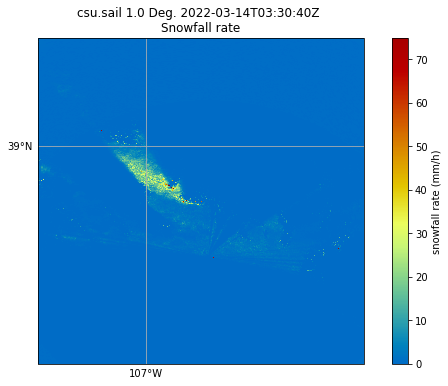

elevation angle is: 2.0 deg
elevation angle is: 4.0 deg
elevation angle is: 6.0 deg
elevation angle is: 8.0 deg
elevation angle is: 10.0 deg
elevation angle is: 12.0 deg
elevation angle is: 15.0 deg
scan type is an RHI at:  2022-03-14 03:34:58
scan type is an RHI at:  2022-03-14 03:35:04
scan type is an RHI at:  2022-03-14 03:35:10
scan type is an RHI at:  2022-03-14 03:35:15
scan type is an RHI at:  2022-03-14 03:35:21
scan type is an RHI at:  2022-03-14 03:35:27
scan type is an RHI at:  2022-03-14 03:35:33


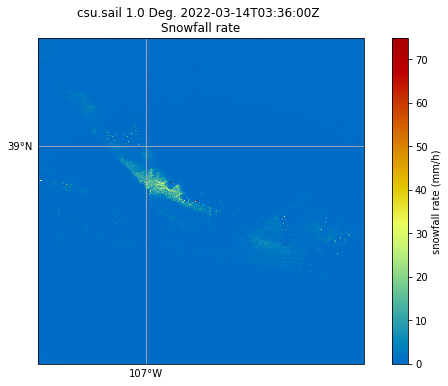

elevation angle is: 2.0 deg
elevation angle is: 4.0 deg
elevation angle is: 6.0 deg
elevation angle is: 8.0 deg
elevation angle is: 10.0 deg
elevation angle is: 12.0 deg


In [25]:
for radar in radars:
    if radar.scan_type == 'ppi':
        # This is looking for the 1 deg scan. Bounds are set up to try and catch if the scan is just below 1 or just above.
        if (radar.elevation['data'][0] >= 0.90 and
                radar.elevation['data'][0] <= 1.1):
            SWE_ratio = 8.5
            A = 67
            B = 1.28
            snow_z = radar.fields['DBZ']['data'].copy()
            # Convert it from dB to linear units
            z_lin = 10.0**(radar.fields['DBZ']['data']/10.)
            # Apply the Z-S relation.
            snow_z = SWE_ratio * (z_lin/A)**(1./B)
            # Add the field back to the radar. Use reflectivity as a template
            radar.add_field_like('DBZ', 'snow_z',  snow_z,
                                 replace_existing=True)
            # Update units and metadata
            radar.fields['snow_z']['units'] = 'mm/h'
            radar.fields['snow_z']['standard_name'] = 'snowfall_rate'
            radar.fields['snow_z']['long_name'] = 'snowfall_rate_from_z'
            radar.fields['snow_z']['valid_min'] = 0
            radar.fields['snow_z']['valid_max'] = 500
            
            # Currently setting smax at 75 for playing around with the data.
            smax = 75
            
            # Plotting the data
            plot_radar(radar)

        # if the data isn't 1 deg scans, this will specify what level scan
        else:
            print('elevation angle is:', np.round(radar.elevation['data'][0]), 'deg')
    
    # if it's not a PPI scan, this will say what time it was an RHI scan.
    else:
        print('scan type is an RHI at: ', radar.time['units'][14:])